### Permutation Importance

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('data/FIFA 2018 Statistics.csv')  # 足球赛事数据集
data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


怎么知道哪些特征影响多大

破坏特征：比如把Goal Scored上下的顺序打乱，其它不变，然后比较破坏前和后的区别

如果前 ≈ 后，说明这个特征对结果没影响
如果后 ＜ 前，说明这个特征对结果影响起正作用
如果后 ＞ 前，说明这个特征对结果影响起负作用（一般不会出现）

In [3]:
y = (data['Man of the Match'] == 'Yes')  # 转换标签
y[:5]

0     True
1    False
2    False
3     True
4    False
Name: Man of the Match, dtype: bool

In [4]:
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
X.head()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
0,5,40,13,7,3,3,6,3,11,0,78,306,118,22,0,0,0,0
1,0,60,6,0,3,3,2,1,25,2,86,511,105,10,0,0,0,0
2,0,43,8,3,3,2,0,1,7,3,78,395,112,12,2,0,0,0
3,1,57,14,4,6,4,5,1,13,3,86,589,111,6,0,0,0,0
4,0,64,13,3,6,4,5,0,14,2,86,433,101,22,1,0,0,0


In [5]:
train_X, val_X,train_y,val_y = train_test_split(X, y,random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X,train_y)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [6]:
import eli5 # pip install eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model,random_state=1).fit(val_X, val_y)

eli5.show_weights(perm, feature_names=val_X.columns.tolist())

Weight,Feature
0.0750 ± 0.1159,Goal Scored
0.0625 ± 0.0791,Corners
0.0437 ± 0.0500,Distance Covered (Kms)
0.0375 ± 0.0729,On-Target
0.0375 ± 0.0468,Free Kicks
0.0187 ± 0.0306,Blocked
0.0125 ± 0.0750,Pass Accuracy %
0.0125 ± 0.0500,Yellow Card
0.0063 ± 0.0468,Saves
0.0063 ± 0.0250,Offsides


### Partial Dependence Plots

特征重要性展示了每个特征发挥的作用情况，partial dependence plots 可以展示一个特征怎么影响预测结果

模型建立完成后进行使用，概述如下：
<ul>
    <li>首先选中一个样本数据，此时想观察Ball Possession列对结果的影响。
    <li>保证其它特征列不变，改变当前观察列的值，例如悬着40%，50%，60%分别进行预测，得到各自的结果。
    <li>对比结果就能知道当前列（Ball Possession）对结果的影响情况。

In [7]:
import matplotlib.pyplot as plt
from pdpbox import pdp, get_dataset, info_plots  # pip install pdpbox
pdp_goals = pdp.pdp_isolate(model=my_model,
                            dataset=val_X, 
                            model_features=feature_names,
                            feature='Goal Scored')  # 观察的特征

pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

<Figure size 1500x950 with 2 Axes>

y轴表示预测结果的变化对比于基本模型，由于在观察时不可能只看一个样本数据，肯定要选择多个样本数据，蓝色区域表示的是置信度

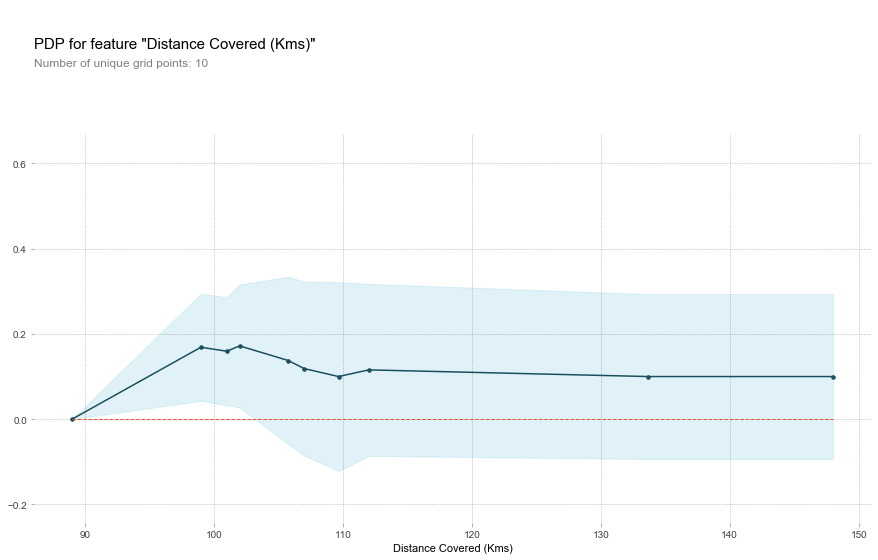

In [8]:
feature_to_plot = 'Distance Covered (Kms)'

rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=val_X,
                          model_features=feature_names,
                          feature=feature_to_plot)

pdp.pdp_plot(pdp_dist,feature_to_plot)
plt.show()

### 双特征观察
需要先改源码：将Anaconda3\Lib\site-packages\pdpbox 下 pdp_plot_utils.py文件中contour_label_fontsize=fontsize改成fontsize=fontsize

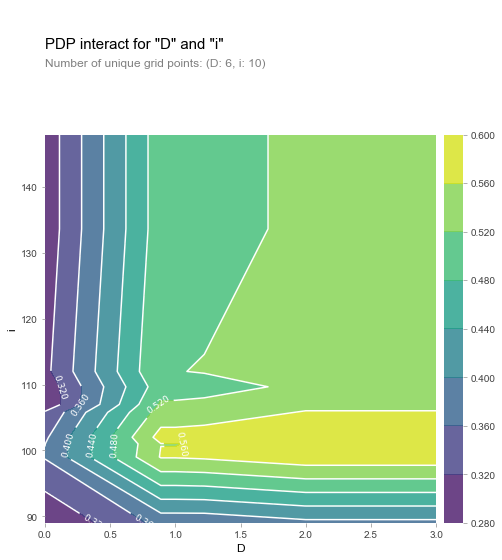

In [9]:
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1 = pdp.pdp_interact(model=rf_model, dataset=val_X,
                         model_features=feature_names,
                         features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot,
                     plot_type='contour')
plt.show()

可以观察到，在跑动距离为100的情况下，进球数量越多，是不是意味着赢得可能性越大